In [1]:
%matplotlib inline
import stock_analysis
from stock_analysis.utils import group_stocks

In [2]:
start, end = '2019-01-01', '2020-12-31'
reader = stock_analysis.StockReader(start, end)

# get bitcoin data
bitcoin = reader.get_bitcoin_data('USD')

# get faang data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

# get S&P 500 data
sp = reader.get_index_data('S&P 500')

faang = group_stocks(
    {
        'Facebook': fb, 
        'Apple': aapl, 
        'Amazon': amzn, 
        'Netflix': nflx, 
        'Google': goog
    }
)

Text(0, 0.5, 'price ($)')

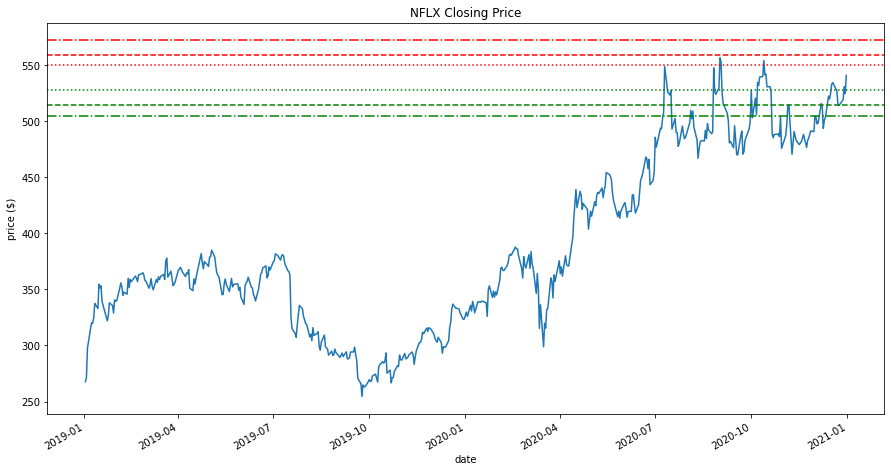

In [3]:
import itertools

def levels(analyzer, method):
    return [getattr(analyzer, method)(i) for i in range(1, 4)]

# calculate support/resistance levels
nflx_analyzer = stock_analysis.StockAnalyzer(nflx)
support_levels, resistance_levels = (
    levels(nflx_analyzer, metric) for metric in ['support', 'resistance']
)

nflx_viz = stock_analysis.StockVisualizer(nflx)
ax = nflx_viz.evolution_over_time('close', figsize=(15, 8), title='NFLX Closing Price')

for support, resistance, linestyle, level in zip(
    support_levels, resistance_levels, 
    [':', '--', '-.'], itertools.count(1)
):
    nflx_viz.add_reference_line(
        ax, 
        y=support, 
        label=f'support level {level}', 
        color='green', 
        linestyle=linestyle
    )
    nflx_viz.add_reference_line(
        ax, 
        y=resistance, 
        label=f'resistance level {level}', 
        color='red', 
        linestyle=linestyle
    )
ax.get_legend().remove()
ax.set_ylabel('price ($)')

array([[<AxesSubplot:title={'center':"Amazon Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Amazon after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Apple Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Apple after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Facebook Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Facebook after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Google Open Price - Prior Day's Close"}, xlabel='date', ylabel='price'>,
        <AxesSubplot:title={'center':'Google after-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
       [<AxesSubplot:title={'center':"Netflix Open Price - Prior Day's Close"}, xlabel='da

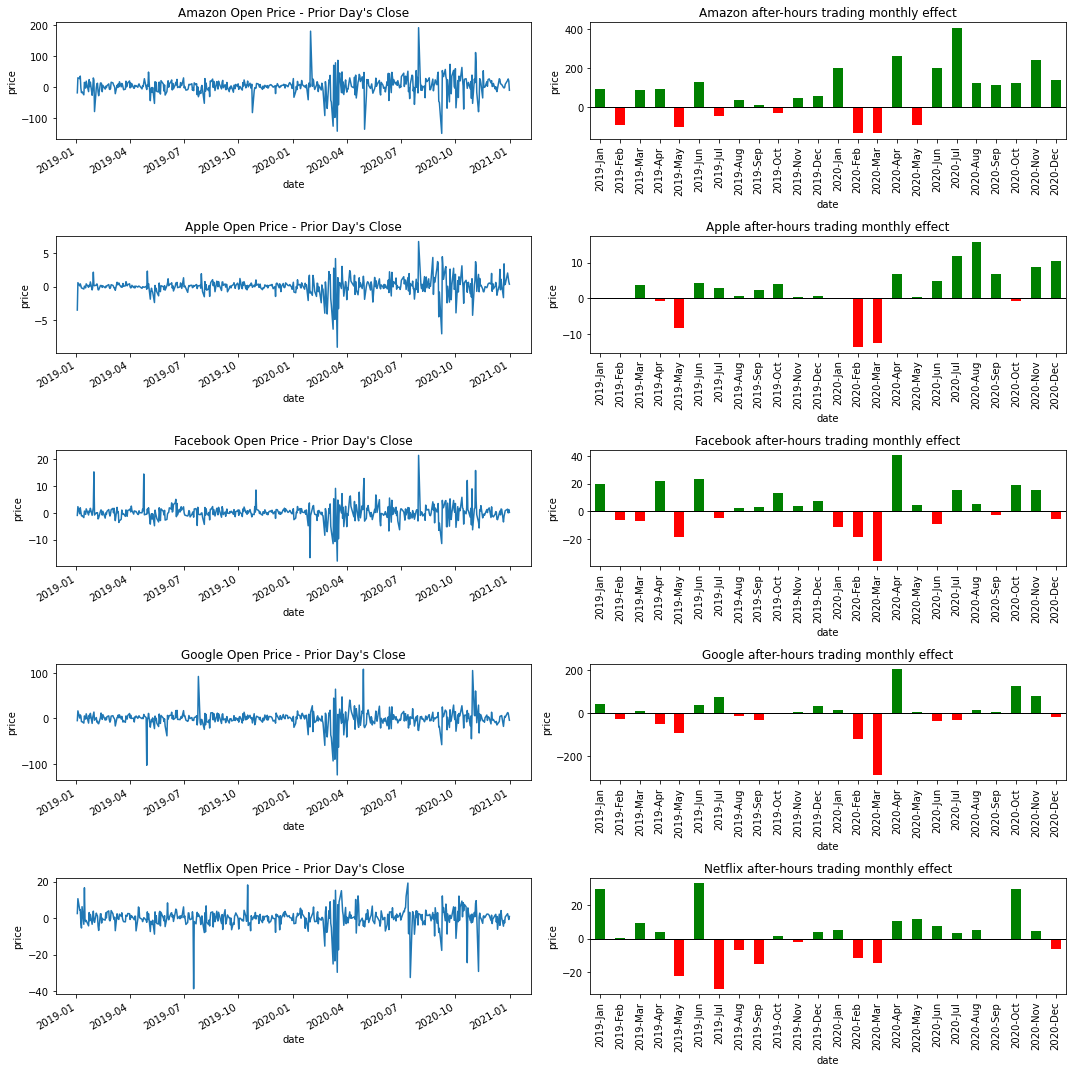

In [4]:
stock_analysis.AssetGroupVisualizer(faang).after_hours_trades()

array([<AxesSubplot:title={'center':"After-hours trading\n(Open Price - Prior Day's Close)"}, xlabel='date', ylabel='price'>,
       <AxesSubplot:title={'center':'After-hours trading monthly effect'}, xlabel='date', ylabel='price'>],
      dtype=object)

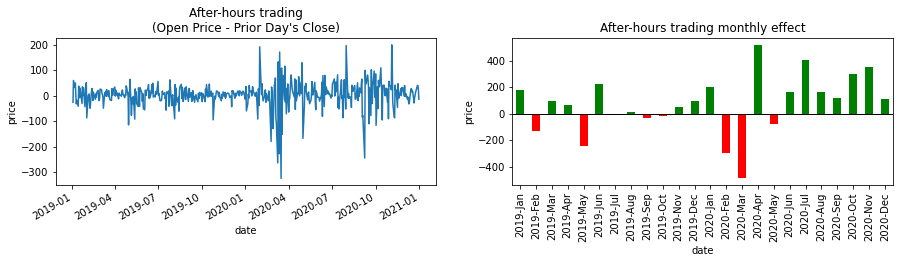

In [5]:
from stock_analysis.utils import make_portfolio

stock_analysis.StockVisualizer(make_portfolio(faang)).after_hours_trades()

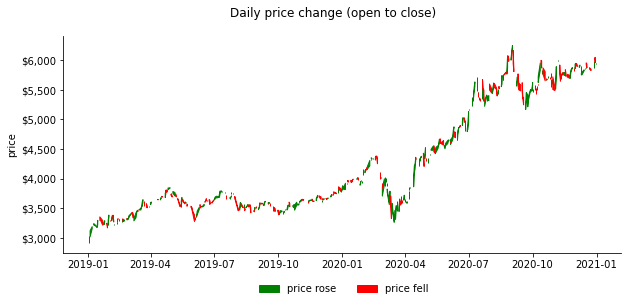

In [6]:
from matplotlib.ticker import StrMethodFormatter
from stock_analysis.utils import make_portfolio

ax = stock_analysis.StockVisualizer(make_portfolio(faang)).open_to_close()
ax.yaxis.set_major_formatter(StrMethodFormatter('${x:,.0f}'))

In [7]:
fbalx = reader.get_ticker_data('FBALX')
msft = reader.get_ticker_data('MSFT')
mutual_fund = group_stocks({
    '0 - FBALX': fbalx,
    '1 - Microsoft': msft,
    '2 - Apple': aapl,
    '3 - Amazon': amzn
})
stock_analysis.AssetGroupAnalyzer(mutual_fund).analyze('annualized_volatility')

{'0 - FBALX': 0.2429878458513019,
 '1 - Microsoft': 0.4394683613426671,
 '2 - Apple': 0.4670809643500884,
 '3 - Amazon': 0.38510990770417824}

In [8]:
import pandas as pd

def metric_table(stock, index, r_f):
    """
    Make a table of metrics for a stock.

    Parameters:
        - stock: The stock's dataframe.
        - index: The dataframe for the index.
        - r_f: Risk-free rate of return
     
    Returns:
        A `pandas.DataFrame` object with a single row of metrics
    """
    return pd.DataFrame({
        metric: getattr(
            stock_analysis.StockAnalyzer(stock), 
            metric
        )(**kwargs) \
        for metric, kwargs in {
            'alpha': {'index': index, 'r_f': r_f}, 
            'beta': {'index': index}, 
            'sharpe_ratio': {'r_f': r_f},
            'annualized_volatility': {},
            'is_bear_market': {},
            'is_bull_market': {}
        }.items()
    }, index=range(1))

# test out the function
metric_table(fbalx, sp, r_f=reader.get_risk_free_rate_of_return())

,alpha,beta,sharpe_ratio,annualized_volatility,is_bear_market,is_bull_market
0,0.023815,0.683745,4.911228,0.242988,False,False


In [9]:
train, test = sp['2019':'2020-11'], sp.loc['2020-12']

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

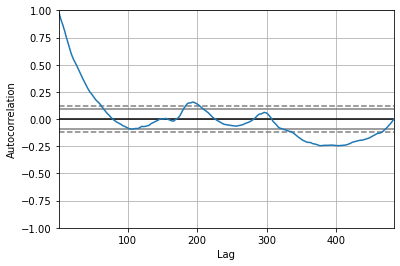

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(train.close)

In [11]:
%%capture
from stock_analysis import StockModeler
arima_model = StockModeler.arima(train, ar=15, i=1, ma=5)

array([<AxesSubplot:title={'center':'Residuals'}, xlabel='Date', ylabel='Residual'>,
       <AxesSubplot:title={'center':'Residuals KDE'}, xlabel='Residual', ylabel='Density'>],
      dtype=object)

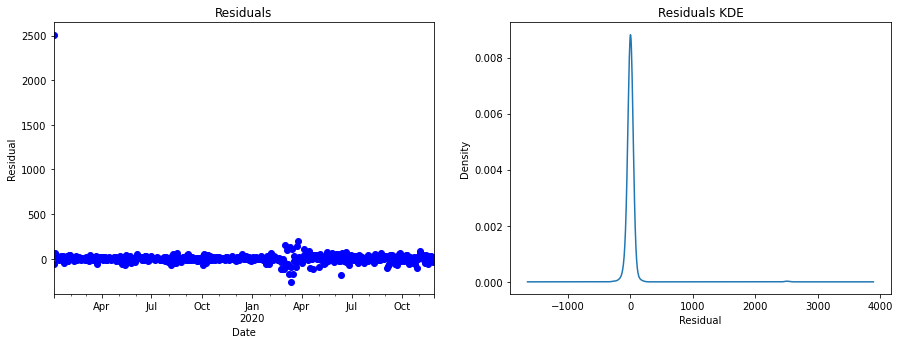

In [12]:
StockModeler.plot_residuals(arima_model)

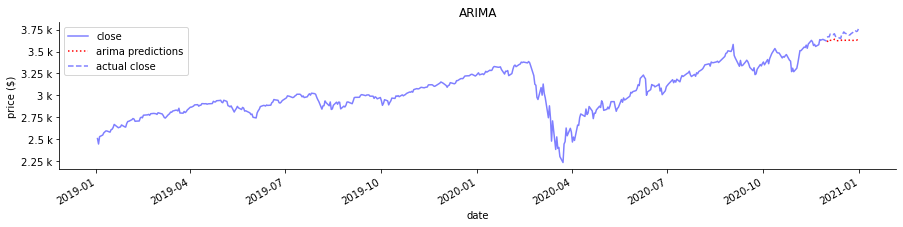

In [13]:
from matplotlib.ticker import EngFormatter

dates = test.index

arima_ax = StockModeler.arima_predictions(
    train, arima_model, start=dates[0], end=dates[-1],
    title='ARIMA', color='b', figsize=(15, 3), alpha=0.5
)
test.close.plot(ax=arima_ax, style='b--', label='actual close', alpha=0.5)
arima_ax.legend()
arima_ax.set_ylabel('price ($)')
arima_ax.yaxis.set_major_formatter(EngFormatter())

for spine in ['top', 'right']:
    arima_ax.spines[spine].set_visible(False)

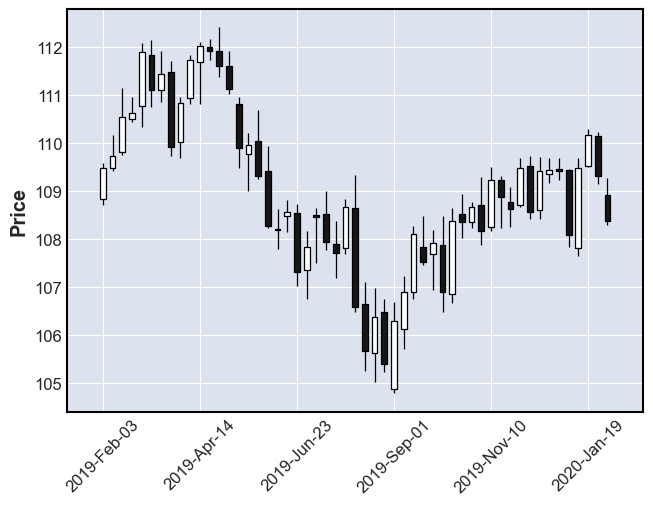

In [14]:
forex = reader.get_forex_rates('USD', 'JPY', api_key='PASTE_YOUR_API_KEY_HERE')
stock_analysis.StockVisualizer(forex).candlestick(date_range=slice('2019-02-01', '2020-01-31'), resample='1W')